# 2022 CVE CWE Review 

In [1]:
%%capture
!mkdir -p jsondata
%cd jsondata
!rm *.json 
!rm *.zip 
!wget https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-{2002..2022}.json.zip 
!unzip -o "*.zip" 
!wget https://raw.githubusercontent.com/CVEProject/cve-website/dev/src/assets/data/CNAsList.json

In [2]:

from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
import calplot
import datetime
from datetime import date
import glob
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))


logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)

In [3]:
row_accumulator = []
for filename in glob.glob('nvdcve-1.1-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                assigner = entry['cve']['CVE_data_meta']['ASSIGNER']
            except KeyError:
                assigner = 'Missing_Data'
            try:
                published_date = entry['publishedDate']
            except KeyError:
                published_date = 'Missing_Data'
            try:
                attack_vector = entry['impact']['baseMetricV3']['cvssV3']['attackVector']
            except KeyError:
                attack_vector = 'Missing_Data'
            try:
                attack_complexity = entry['impact']['baseMetricV3']['cvssV3']['attackComplexity']
            except KeyError:
                attack_complexity = 'Missing_Data'
            try:
                privileges_required = entry['impact']['baseMetricV3']['cvssV3']['privilegesRequired']
            except KeyError:
                privileges_required = 'Missing_Data'
            try:
                user_interaction = entry['impact']['baseMetricV3']['cvssV3']['userInteraction']
            except KeyError:
                user_interaction = 'Missing_Data'
            try:
                scope = entry['impact']['baseMetricV3']['cvssV3']['scope']
            except KeyError:
                scope = 'Missing_Data'
            try:
                confidentiality_impact = entry['impact']['baseMetricV3']['cvssV3']['confidentialityImpact']
            except KeyError:
                confidentiality_impact = 'Missing_Data'
            try:
                integrity_impact = entry['impact']['baseMetricV3']['cvssV3']['integrityImpact']
            except KeyError:
                integrity_impact = 'Missing_Data'
            try:
                availability_impact = entry['impact']['baseMetricV3']['cvssV3']['availabilityImpact']
            except KeyError:
                availability_impact = 'Missing_Data'
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = '0.0'
            try:
                base_severity = entry['impact']['baseMetricV3']['cvssV3']['baseSeverity']
            except KeyError:
                base_severity = 'Missing_Data'
            try:
                exploitability_score = entry['impact']['baseMetricV3']['exploitabilityScore']
            except KeyError:
                exploitability_score = 'Missing_Data'
            try:
                impact_score = entry['impact']['baseMetricV3']['impactScore']
            except KeyError:
                impact_score = 'Missing_Data'
            try:
                cwe = entry['cve']['problemtype']['problemtype_data'][0]['description'][0]['value']
            except IndexError:
                cwe = 'Missing_Data'
            try:
                description = entry['cve']['description']['description_data'][0]['value']
            except IndexError:
                description = ''
            new_row = { 
                'CVE': cve, 
                'Published': published_date,
                'AttackVector': attack_vector,
                'AttackComplexity': attack_complexity,
                'PrivilegesRequired': privileges_required,
                'UserInteraction': user_interaction,
                'Scope': scope,
                'ConfidentialityImpact': confidentiality_impact,
                'IntegrityImpact': integrity_impact,
                'AvailabilityImpact': availability_impact,
                'BaseScore': base_score,
                'BaseSeverity': base_severity,
                'ExploitabilityScore': exploitability_score,
                'ImpactScore': impact_score,
                'CWE': cwe,
                'Description': description,
                'Assigner' : assigner
            }
            if not description.startswith('** REJECT **'): # disputed, rejected and other non issues start with '**'
                row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)
    
nvd['Published'] = pd.to_datetime(nvd['Published'])
thisyear = ((nvd['Published'] > '2022-01-01') & (nvd['Published']  < '2022-12-31'))
nvd = nvd.loc[thisyear]
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.NaN);
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
startdate = date(2022, 1, 1)
enddate  = date.today()
numberofdays = enddate - startdate 
per_day = nvdcount/numberofdays.days

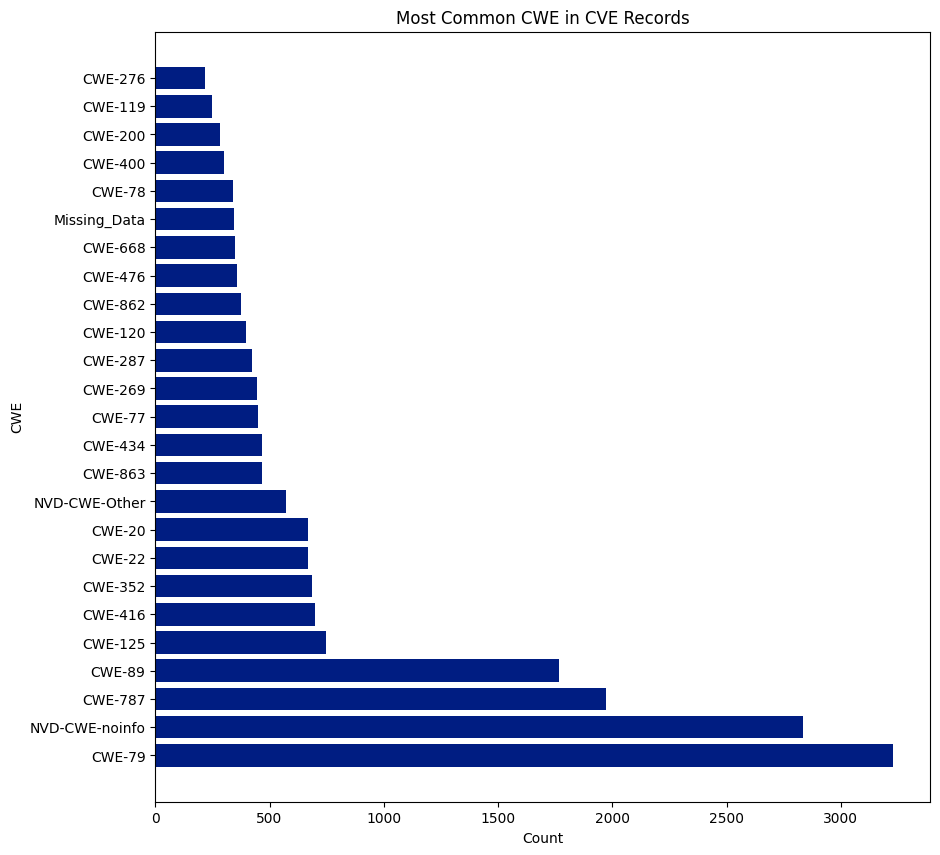

In [9]:
nvd_cwe = nvd['CWE'].value_counts()
nvd_cwe = nvd_cwe.reset_index()
nvd_cwe.columns = ['CWE', 'Counts']
nvd_cwe['Percentage'] = ( nvd_cwe['Counts'] / 
                       nvd_cwe['Counts'].sum()) * 100
nvd_cwe_graph = nvd_cwe[nvd_cwe.Counts > 100].head(25)
plt.figure(figsize=(10,10));
plt.barh("CWE", "Counts", data = nvd_cwe_graph, color="#001d82");
plt.xlabel("Count"); 
plt.ylabel("CWE") ;
plt.title("Most Common CWE in CVE Records");

In [11]:
nvd_cwe.head(25).round(2)

,CWE,Counts,Percentage
0,CWE-79,3230,12.88
1,NVD-CWE-noinfo,2835,11.30
2,CWE-787,1973,7.87
3,CWE-89,1765,7.04
4,CWE-125,746,2.97
5,CWE-416,699,2.79
6,CWE-352,687,2.74
7,CWE-22,669,2.67
8,CWE-20,667,2.66
9,NVD-CWE-Other,572,2.28


In [12]:
nvd_cwe.loc[nvd_cwe['Counts'] == 1].head(50)

,CWE,Counts,Percentage
178,CWE-456,1,0.003987
179,CWE-1026,1,0.003987
180,CWE-141,1,0.003987
181,CWE-84,1,0.003987
182,CWE-807,1,0.003987
183,CWE-614,1,0.003987
184,CWE-941,1,0.003987
185,CWE-146,1,0.003987
186,CWE-229,1,0.003987
187,CWE-451,1,0.003987


In [13]:
nvd_cwe.loc[nvd_cwe['Counts'] == 1].describe()

,Counts,Percentage
count,61.0,61.000000
mean,1.0,0.003987
std,0.0,0.000000
min,1.0,0.003987
25%,1.0,0.003987
50%,1.0,0.003987
75%,1.0,0.003987
max,1.0,0.003987


In [14]:
nvd_cwe.describe()

,Counts,Percentage
count,239.000000,239.000000
mean,104.937238,0.418410
std,344.346098,1.372991
min,1.000000,0.003987
25%,1.000000,0.003987
50%,9.000000,0.035885
75%,53.000000,0.211324
max,3230.000000,12.878788
